# Adaptive Bio-CCA demo

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from adaptive_biocca import adaptive_bio_cca
from util import subspace_error, correlation_matrix, add_fill_lines

### Load dataset

In [31]:
# dataset = 'synthetic'; epochs = 1
dataset = 'mediamill'; epochs = 3

In [32]:
# Load dataset

X, Y, samples = {}, {}, {}

if dataset=='synthetic':
    X = np.load('datasets/synthetic/view1.npy')
    Y = np.load('datasets/synthetic/view2.npy')
elif dataset=='mediamill':
    X = np.load('datasets/mediamill/view1.npy')
    Y = np.load('datasets/mediamill/view2.npy')

# dataset dimensions

x_dim = X.shape[0]
y_dim = Y.shape[0]
samples = X.shape[1]

### Offline solution

In [33]:
Cxx = X@X.T/samples
Cyy = Y@Y.T/samples
Cxy = X@Y.T/samples
Rxy = correlation_matrix(Cxx,Cyy,Cxy)
u, canonical_correlations, vh = np.linalg.svd(Rxy)

### Plot canonical correlations

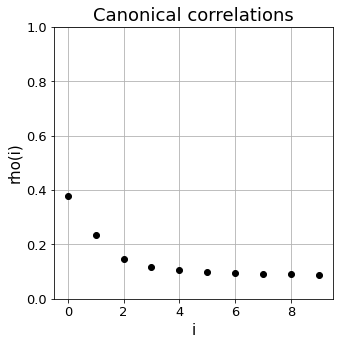

In [34]:
fig = plt.figure(figsize=(5,5))

ax = plt.subplot(1,1,1)

ax.plot(canonical_correlations, 'o', color='black')
plt.xlim(-.5,9.5)
plt.ylim(0,1)
plt.title(f'Canonical correlations')
plt.xlabel('i')
plt.ylabel('rho(i)')
plt.grid()

plt.show()

### Online algorithms

In [37]:
# Parameters

trials = 1; z_dim = 10; alpha = 1.15

iters = epochs*samples

In [38]:
# Compute the number of dimensions that should be kept

r = min(sum(1 for i in canonical_correlations if 1+i>alpha),z_dim)

In [39]:
# Optimal subspace projections

Ux = u[:,:r]
Uy = vh.T[:,:r]

Px_opt = Ux@Ux.T
Py_opt = Uy@Uy.T

In [40]:
adaptive_time = np.zeros((trials,iters))
adaptive_Vx = np.zeros((trials,iters,x_dim,z_dim))
adaptive_Vy = np.zeros((trials,iters,y_dim,z_dim))

In [41]:
start_time = time.time()

for i_trial in range(trials):
    
    print(f'Trial {i_trial+1} out of {trials}:')
                
    # Initialize Adaptive Bio-CCA
    
    adaptive = adaptive_bio_cca(z_dim,x_dim,y_dim,alpha,dataset)
            
    # Run online algorithm
    
    print('Running Adaptive Bio-CCA...')
            
    for i_epoch in range(epochs):

        print(f'Epoch {i_epoch+1} out of {epochs}:')

        # Random permutation of the inputs

        idx = np.random.permutation(samples)

        # Online updates

        for i_sample in range(samples):

            i_iter = i_epoch*samples + i_sample

            x = X[:,idx[i_sample]]
            y = Y[:,idx[i_sample]]

            # online updates

            adaptive_Vx[i_trial,i_iter], adaptive_Vy[i_trial,i_iter] = adaptive.fit_next(x,y)
            adaptive_time[i_trial,i_iter] = time.time() - start_time

        print(f'Elapsed time: {time.time()-start_time} seconds')
            
print('Trials complete')

Trial 1 out of 1:
Running Adaptive Bio-CCA...
Epoch 1 out of 3:
Elapsed time: 3.3094940185546875 seconds
Epoch 2 out of 3:
Elapsed time: 6.610337972640991 seconds
Epoch 3 out of 3:
Elapsed time: 9.964159965515137 seconds
Trials complete


### Compute errors

In [42]:
domain = list(sorted(set(map(int, np.round(np.logspace(0, np.log10(iters), num=50, endpoint=False))))))

In [43]:
adaptive_subspacex_error = np.zeros((trials,iters))

In [44]:
for i_trial in range(trials):
    for i_iter in domain:
        ux, sx, vxh = np.linalg.svd(adaptive_Vx[i_trial,i_iter])
        adaptive_subspacex_error[i_trial,i_iter] = subspace_error(ux[:,:r], Px_opt)

### Plots

In [45]:
font = {'weight' : 'normal', 'size' : 15}

plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 

plt.rc('font', **font)

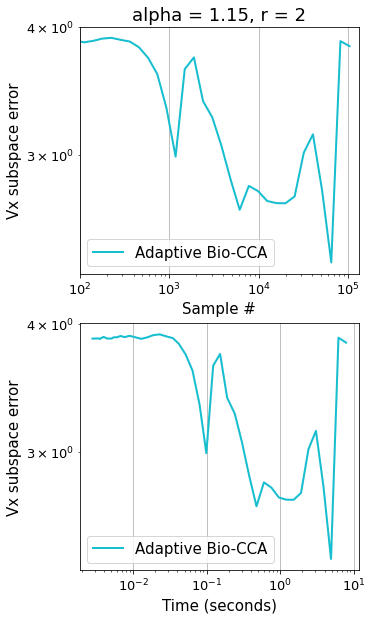

In [46]:
linewidth = 2

fig = plt.figure(figsize=(5,10))

ax = plt.subplot(2, 1, 1)

add_fill_lines(ax, domain, adaptive_subspacex_error[:,domain], plot_kwargs={'ls': '-', 'lw': linewidth, 'label': 'Adaptive Bio-CCA', 'color': 'tab:cyan'}, ci_kwargs={'color': 'tab:cyan'})

ax.loglog()

plt.title(f"alpha = {alpha}, r = {r}")
plt.grid()
plt.legend(loc = 'lower left')
plt.xlim((1e2,iters))
plt.xlabel('Sample #')
plt.ylabel('Vx subspace error')

ax = plt.subplot(2, 1, 2)

add_fill_lines(ax, np.mean(adaptive_time[:,domain],axis=0), adaptive_subspacex_error[:,domain], plot_kwargs={'ls': '-', 'lw': linewidth, 'label': 'Adaptive Bio-CCA', 'color': 'tab:cyan'}, ci_kwargs={'color': 'tab:cyan'})

ax.loglog()

plt.grid()
plt.legend(loc = 'lower left')
plt.xlabel('Time (seconds)')
plt.ylabel('Vx subspace error')

plt.show()

##### Whitening error